# DenseNet161 frozen - 0.917712 (Best yet)

256x256 & 5e-3 & 15 epoch

Getting Data from Kaggle

[link](https://https://www.kaggle.com/datasets/cdeotte/jpeg-melanoma-256x256?resource=download&select=test.csv)
```
# This is formatted as code
```



In [1]:
%mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d cdeotte/jpeg-melanoma-256x256

 99% 785M/791M [00:07<00:00, 124MB/s]
100% 791M/791M [00:07<00:00, 107MB/s]


In [ ]:
!unzip jpeg-melanoma-256x256.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/ISIC_8512716.jpg  
  inflating: train/ISIC_8513112.jpg  
  inflating: train/ISIC_8513649.jpg  
  inflating: train/ISIC_8514170.jpg  
  inflating: train/ISIC_8514989.jpg  
  inflating: train/ISIC_8515165.jpg  
  inflating: train/ISIC_8515281.jpg  
  inflating: train/ISIC_8515582.jpg  
  inflating: train/ISIC_8515674.jpg  
  inflating: train/ISIC_8516181.jpg  
  inflating: train/ISIC_8516223.jpg  
  inflating: train/ISIC_8516516.jpg  
  inflating: train/ISIC_8516631.jpg  
  inflating: train/ISIC_8516659.jpg  
  inflating: train/ISIC_8516922.jpg  
  inflating: train/ISIC_8517305.jpg  
  inflating: train/ISIC_8517492.jpg  
  inflating: train/ISIC_8518406.jpg  
  inflating: train/ISIC_8519222.jpg  
  inflating: train/ISIC_8519402.jpg  
  inflating: train/ISIC_8519725.jpg  
  inflating: train/ISIC_8519890.jpg  
  inflating: train/ISIC_8519931.jpg  
  inflating: train/ISIC_8520545.jpg  
  inflating: train/ISIC_8521162.jpg  

In [ ]:
!pip install image_tabular

Duplicate images and data removal


In [ ]:
import hashlib
from cv2 import imread, resize, imshow
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config',
 'train.csv',
 'sample_submission.csv',
 'jpeg-melanoma-256x256.zip',
 'test.csv',
 'test',
 'train',
 'kaggle.json',
 'sample_data']

In [ ]:
#Change directory
os.chdir('/content/train')
os.getcwd()

'/content/train'

In [ ]:
#Initial number of images
file_list = os.listdir()
print(len(file_list))

33126


In [ ]:
#Creating lists that carry info regarding duplicates
import hashlib, os
duplicates = []
duplicates1 = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('.')):  #listdir('.') = current directory
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash])) #contains wrt enumeration index
            duplicates1.append((filename,hash_keys[filehash])) #contains wrt filename

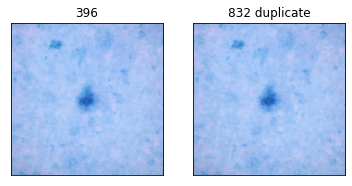

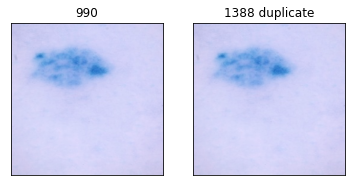

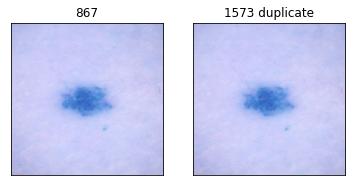

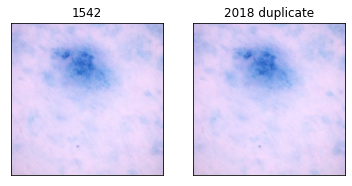

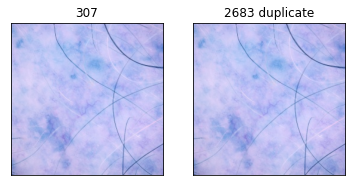

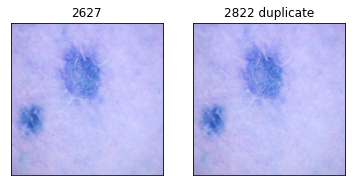

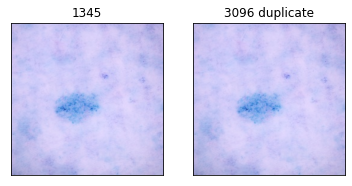

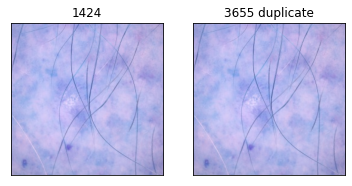

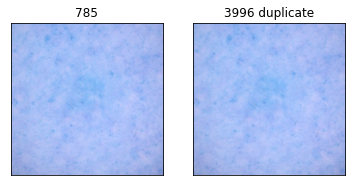

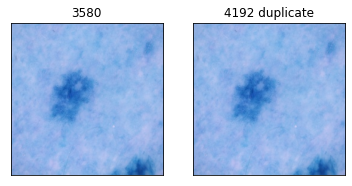

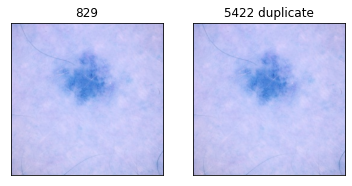

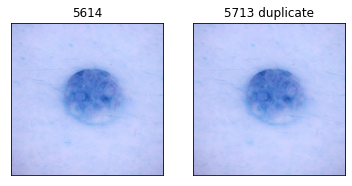

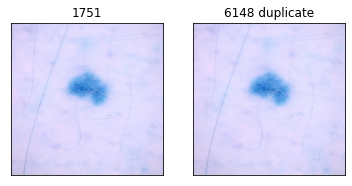

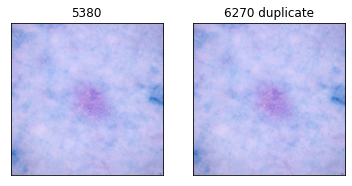

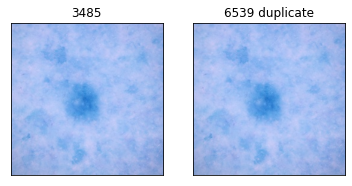

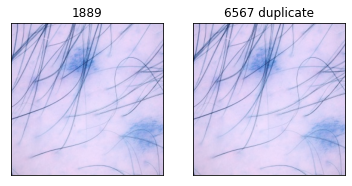

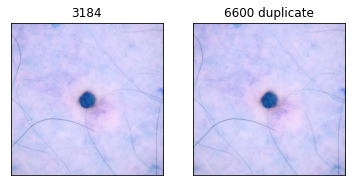

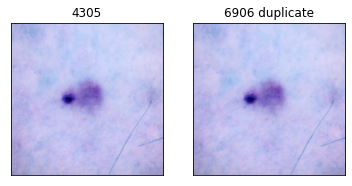

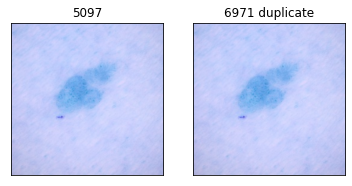

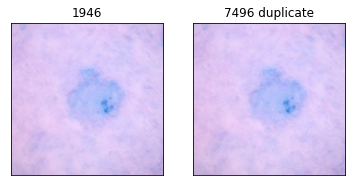

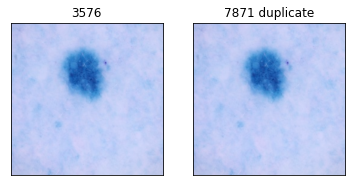

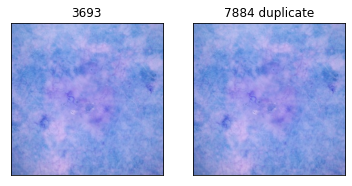

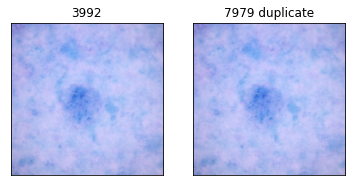

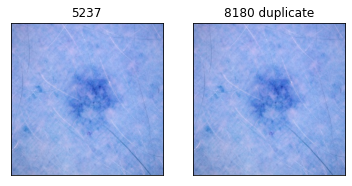

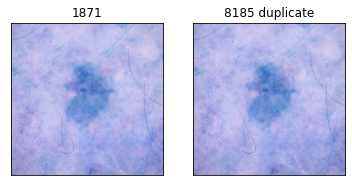

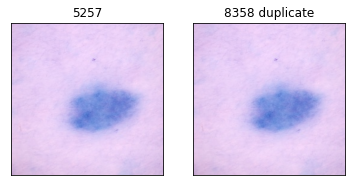

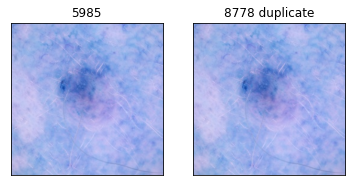

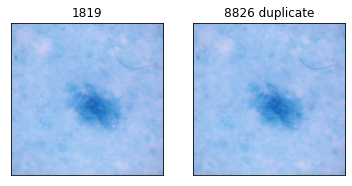

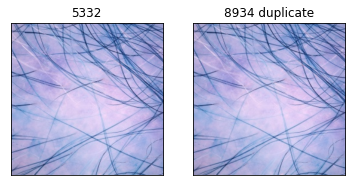

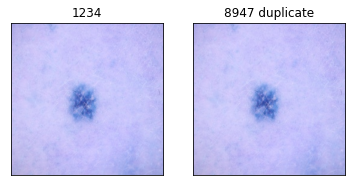

In [ ]:
#displaying duplicates
for file_indexes in duplicates[:30]:
    try:

        plt.subplot(121),plt.imshow(imread(file_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(file_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()

    except OSError as e:
        continue

Remove duplicate images

In [ ]:
for index in duplicates:
    os.remove(file_list[index[0]])

In [ ]:
new_file_list = os.listdir()
print(len(new_file_list))

32693


Remove rows with names of duplicate images

In [ ]:
duplicates1[:5]

[('ISIC_2406262.jpg', 396),
 ('ISIC_4690191.jpg', 990),
 ('ISIC_8428997.jpg', 867),
 ('ISIC_1813445.jpg', 1542),
 ('ISIC_4897895.jpg', 307)]

In [ ]:
train_df = pd.read_csv('/content/train.csv')

test_df = pd.read_csv('/content/test.csv')

print('Initial Length: ',len(train_df))

Initial Length:  33126


In [ ]:
# dup_names contains names of duplicate images
# removing all values in dataframe image_name column that matches with names in dup_names
dup_names = []
for i in range(len(duplicates1)):
   dup_names.append(duplicates1[i][0])

for k in range(len(dup_names)):
  train_df = train_df[train_df.image_name != dup_names[k].replace(".jpg", "")]

print(len(train_df))

32693


Model Development


In [ ]:
from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [ ]:
# extremely unbalanced dataset, most of the images are benign
train_df["benign_malignant"].value_counts(normalize=True)

benign       0.982229
malignant    0.017771
Name: benign_malignant, dtype: float64

# Image data

In [ ]:
tfms = get_transforms(flip_vert=True,max_rotate=3.0, max_lighting=0.3, max_zoom = 0.3)
size = 256

In [ ]:
# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df)
len(val_idx)

6538

In [ ]:
data_path = Path('/content/')
image_data = (ImageList.from_df(train_df, path=data_path, cols="image_name",
                               folder="train", suffix=".jpg")
              .split_by_idx(val_idx)
              .label_from_df(cols="target")
              .transform(tfms, size=size))

# add test data so that we can make predictions
test_image_data = ImageList.from_df(test_df, path=data_path, cols="image_name",
                                    folder="test", suffix=".jpg")
image_data.add_test(test_image_data)

LabelLists;

Train: LabelList (26155 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: /content;

Valid: LabelList (6538 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: /content;

Test: LabelList (10982 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content

0


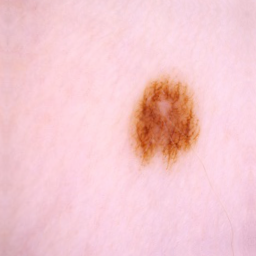

In [ ]:
print(image_data.train[0][1])
image_data.train[4][0]

# Tabular Data

In [ ]:
dep_var = 'target'
cat_names = ['sex', 'anatom_site_general_challenge','width','height']
cont_names = ['age_approx']
procs = [FillMissing, Categorify, Normalize]

In [ ]:
tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dep_var))

# add test
tab_data.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names,
                                      processor = tab_data.train.x.processor))

LabelLists;

Train: LabelList (26155 items)
x: TabularList
sex male; anatom_site_general_challenge head/neck; width 6000; height 4000; age_approx_na False; age_approx -0.2700; ,sex female; anatom_site_general_challenge upper extremity; width 6000; height 4000; age_approx_na False; age_approx -0.2700; ,sex female; anatom_site_general_challenge lower extremity; width 1872; height 1053; age_approx_na False; age_approx 0.0777; ,sex female; anatom_site_general_challenge head/neck; width 1872; height 1053; age_approx_na False; age_approx -0.2700; ,sex female; anatom_site_general_challenge lower extremity; width 6000; height 4000; age_approx_na False; age_approx -0.6177; 
y: CategoryList
0,0,0,0,0
Path: /content;

Valid: LabelList (6538 items)
x: TabularList
sex male; anatom_site_general_challenge torso; width 1872; height 1053; age_approx_na False; age_approx 1.4686; ,sex male; anatom_site_general_challenge torso; width 4032; height 3024; age_approx_na False; age_approx -0.6177; ,sex female;

# Integrate image and tabular data

In [ ]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(image_data, tab_data)

In [ ]:
bs = 64  #32 #16

db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=data_path, bs=bs)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x7f0de2ce12d0>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x7f0de2ce1610>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x7f0de2ce1650>

In [ ]:
# image normalization with imagenet_stats
db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
db.add_tfm(db.norm)

# Model that trains on image and tabular data simultaneously

In [ ]:
# cnn model for images
cnn_arch = models.densenet161

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch,
                        ps=0.4)
cnn_model = cnn_learn.model
cnn_model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affin

In [ ]:
# get embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 8

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz = tab_out_sz, layers=[8], ps=0.4)
tabular_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(7, 5)
    (2): Embedding(77, 18)
    (3): Embedding(76, 18)
    (4): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=48, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [ ]:
# get an integrated model that combines the two components and concatenate their outputs
# which will pass through additional fully connected layers
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.4,
                                  out_sz=2).to(device)

In [ ]:
ben_weight = 1/(1-train_df["target"].mean()) #Weight for Benign class
mal_weight = 1/train_df["target"].mean() #Weight for malignant class
weights = [ben_weight, mal_weight]

print(ben_weight)
print(mal_weight)

1.0180929247633284
56.270223752151466


In [ ]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [ben_weight, mal_weight]

loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [ ]:
# package everything in a fastai learner, adding auc roc , confusion matrix and f1 score as a metric
#f_score = partial(fbeta, thresh=0.2, beta = 1)
learn = Learner(db, integrate_model, metrics=[accuracy, ROCAUC()], loss_func=loss_func) #, ConfusionMatrix(),f_score

In [ ]:
# organize layer groups in order to use differential learning rates provided by fastai
# the first two layer groups are earlier layers of densenet
# the last layer group consists of the fully connected layers of cnn model, tabular model,
# and final fully connected layers for the concatenated data
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

# Training

In [ ]:
# find learning rate to train the last layer group first
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,rocauc,time


RuntimeError: ignored

In [ ]:
# train
learn.fit_one_cycle(13, 2e-6)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.768496,0.721135,0.545274,0.519365,10:14
1,0.697754,0.698151,0.565769,0.571447,10:08
2,0.664973,0.673756,0.593607,0.652242,10:07
3,0.663488,0.642019,0.638269,0.707412,10:07
4,0.652145,0.613531,0.676354,0.754575,10:06
5,0.636546,0.612422,0.664270,0.776562,10:07
6,0.641312,0.611555,0.656470,0.791602,10:06
7,0.639471,0.591566,0.688131,0.800698,10:07
8,0.618558,0.603277,0.660905,0.808023,10:06
9,0.619104,0.586587,0.695626,0.810231,10:06


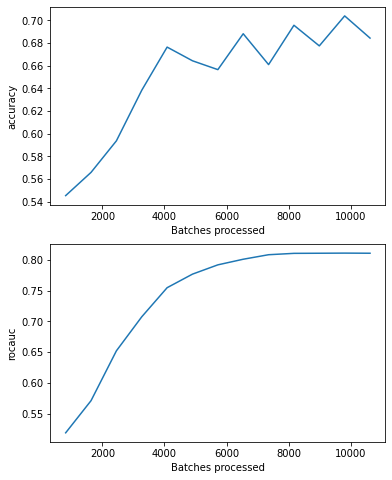

In [ ]:
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,rocauc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


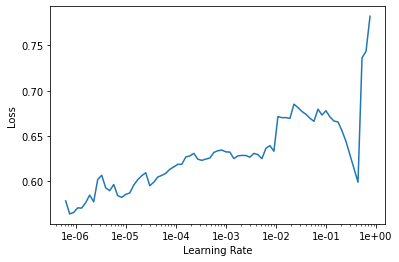

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
#Making copies of learn variable
l1 = learn
l2 = learn
l3 = learn
l4 = learn

In [ ]:
l1.fit_one_cycle(12, 4e-5)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.619054,0.576285,0.697308,0.836590,13:24
1,0.577982,0.559889,0.734017,0.830957,13:23
2,0.543162,0.527483,0.796880,0.837785,13:23
3,0.548211,0.507142,0.834659,0.846067,13:23
4,0.524341,0.470145,0.885133,0.870322,13:23
5,0.494108,0.471399,0.925818,0.869003,13:22
6,0.498140,0.437517,0.895687,0.894049,13:23
7,0.481758,0.413734,0.916794,0.904164,13:23
8,0.416068,0.398502,0.903946,0.915999,13:25
9,0.451615,0.401644,0.923218,0.918517,13:22


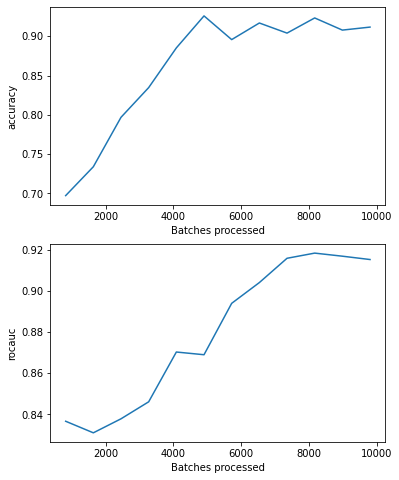

In [ ]:
l1.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,rocauc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


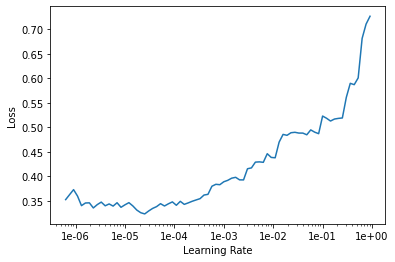

In [ ]:
l2.lr_find()
l2.recorder.plot()

In [ ]:
l2.fit_one_cycle(13, 3e-5/2)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.382603,0.399075,0.917712,0.915690,13:09


In [ ]:
print("{0:.6f}".format(value))

In [ ]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
print(preds)

tensor([[0.6019, 0.3981],
        [0.9927, 0.0073],
        [0.9977, 0.0023],
        ...,
        [0.6880, 0.3120],
        [0.8540, 0.1460],
        [0.3559, 0.6441]])


In [ ]:
# submit predictions to kaggle
submit = pd.read_csv(data_path/"sample_submission.csv")
submit["target"] = preds[:, 1]
submit.to_csv("169_20_5e3.csv", index=False)

In [ ]:
# learn.export('256x256_densenet201_15E_1e3.pt')
learn.save('256x256_densenet201_15E_1e3.pt',return_path=True)

PosixPath('data/siim-isic-melanoma-classification/models/256x256_densenet201_15E_1e3.pt.pth')

In [ ]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.444240,0.542564,0.900226,0.874370,06:23
1,0.495513,0.452598,0.826566,0.874231,06:21
2,0.420580,0.404041,0.888151,0.900287,06:20
3,0.374627,0.430010,0.890717,0.888577,06:21
4,0.371801,0.410765,0.894642,0.898931,06:21


In [ ]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
# submit predictions to kaggle
submit = pd.read_csv(data_path/"sample_submission.csv")
submit["target"] = preds[:, 1]
submit.to_csv("densenet_unfrozen_255.csv", index=False)

In [ ]:
!cp /content/image_tabular/data/siim-isic-melanoma-classification/models/256x256_densenet201_15E_1e3.pt.pth "/content/drive/My Drive"